# Filtering Signals
In this tutorial we will learn how to filter MIMIC waveform signals.

The **objectives** are:
- To learn how to create a filter using the [SciPy signal processing package](https://docs.scipy.org/doc/scipy/reference/signal.html).
- To understand how to interpret the amplitude-response of a filter.
- To gain experience in filtering PPG signals.

<div class="alert alert-block alert-warning"> <b>Context:</b> Filtering is used to eliminate noise from physiological signals. For instance, ECG signals can contain mains frequency noise due to electrical interference. Ideally, a filter would attenuate unwanted frequency content in a signal whilst retaining the physiological frequency content.</div>

<div class="alert alert-block alert-info"> <b>Extension:</b> If you've not seen it before, then have a look at the <a href= https://docs.scipy.org/doc/scipy/reference/signal.html>SciPy signal processing package</a>. How might it be helpful for processing PPG signals?</div>

## Setup

_These steps have been covered in previous tutorials, so we'll just re-use the code here._

In [1]:
# Packages
import sys
from pathlib import Path
!pip install wfdb==4.0.0
import wfdb

# MIMIC info
database_name = 'mimic4wdb/0.1.0' # The name of the MIMIC IV Waveform Database on Physionet

# Segment for analysis
segment_names = ['83404654_0005', '82924339_0007']
segment_dirs = ['mimic4wdb/0.1.0/waves/p100/p10020306/83404654', 'mimic4wdb/0.1.0/waves/p101/p10126957/82924339']
rel_segment_no = 0
rel_segment_name = segment_names[rel_segment_no]
rel_segment_dir = segment_dirs[rel_segment_no]


---
## Extract one minute of PPG signal from this segment

_These steps have been covered in previous tutorials, so we'll just re-use the code here._

In [2]:
start_seconds = 20 # time since the start of the segment at which to begin extracting data
no_seconds_to_load = 60
segment_metadata = wfdb.rdheader(record_name=rel_segment_name, pn_dir=rel_segment_dir) 
print("Metadata loaded from segment: {}".format(rel_segment_name))
fs = round(segment_metadata.fs)
sampfrom = fs*start_seconds
sampto = fs*(start_seconds+no_seconds_to_load)
segment_data = wfdb.rdrecord(record_name=rel_segment_name, sampfrom=sampfrom, sampto=sampto, pn_dir=rel_segment_dir) 
print("{} seconds of data extracted from: {}".format(no_seconds_to_load, rel_segment_name))
for sig_no in range(0,len(segment_data.sig_name)):
    if "Pleth" in segment_data.sig_name[sig_no]:
        break
ppg = segment_data.p_signal[:,sig_no]
fs = segment_data.fs
print("Extracted the PPG signal from column {} of the matrix of waveform data.".format(sig_no))

Metadata loaded from segment: 83404654_0005
60 seconds of data extracted from: 83404654_0005
Extracted the PPG signal from column 4 of the matrix of waveform data.


---
## Create a filter

- Import the [SciPy signal processing package](https://docs.scipy.org/doc/scipy/tutorial/signal.html), which contains functions for filtering and differentiating.

In [3]:
import scipy.signal as sp

- Specify the high- and low-pass filter cut-offs

In [4]:
lpf_cutoff = 0.7 # Hz
hpf_cutoff = 10 # Hz

- Create a Butterworth filter using the [butter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html) function

In [5]:
sos_ppg = sp.butter(10, [lpf_cutoff, hpf_cutoff], btype = 'bp', analog = False, output = 'sos', fs = segment_data.fs)
w, h = sp.sosfreqz(sos_ppg, 2000, fs = fs)

- Plot filter characteristics

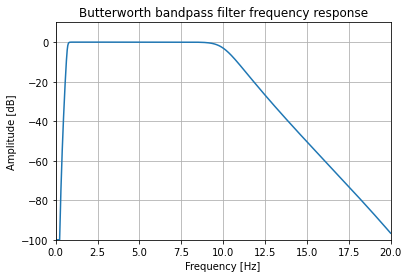

In [6]:
from matplotlib import pyplot as plt
import numpy as np
fig, ax = plt.subplots()
ax.plot(w, 20 * np.log10(np.maximum(abs(h), 1e-5)))
ax.set_title('Butterworth bandpass filter frequency response')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [dB]')
ax.axis((0, 20, -100, 10))
ax.grid(which='both', axis='both')


<div class="alert alert-block alert-info"> <b>Question:</b> What does this plot tell us about the filter characteristics? What types of noise does the filter attenuate? </div>

<div class="alert alert-block alert-warning"> <b>Explanation:</b> This function generates the co-efficients for a Butterworth filter. The filter-type is specified as 'bp' - a bandpass filtter. The filter frequencies are specified in Hz (because the sampling frequency, fs, has also been specified): a high-pass frequency of 0.7 Hz, and a low-pass frequency of 10 Hz. </div>

<div class="alert alert-block alert-info"> <b>Extension 1:</b> How could we re-design the filter to retain frequency content of upto 20 Hz, but eliminate mains frequencies? </div>

<div class="alert alert-block alert-info"> <b>Extension 2:</b> What would be appropriate cut-off frequencies when using the PPG for different purposes, e.g. heart rate monitoring, or blood pressure estimation? See <a href="http://peterhcharlton.github.io/publication/wearable_ppg_chapter/">this book chapter</a>, (Sections 2.2.4-2.2.5 on Sampling Frequency and Bandwidth) for details.</div>

---
## Filter the PPG signal

- Filter the PPG signal in preparation for differentiation.

In [7]:
ppg_filt = sp.sosfiltfilt(sos_ppg, ppg)

- Plot original and filtered PPG signals

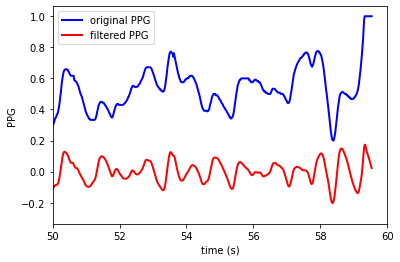

In [8]:
fig, ax = plt.subplots()
t = np.arange(0, len(ppg_filt))/segment_data.fs
ax.plot(t, ppg, linewidth=2.0, color = 'blue', label = "original PPG")
ax.plot(t, ppg_filt, linewidth=2.0, color = 'red', label = "filtered PPG")
ax.set(xlim=(0, no_seconds_to_load))
plt.xlabel('time (s)')
plt.ylabel('PPG')
plt.xlim([50, 60])

plt.legend()
plt.show()

<div class="alert alert-block alert-warning"> <b>Note:</b> The PPG signals in MIMIC have already been filtered somewhat by the clinical monitors used to record them. </div>

<div class="alert alert-block alert-info"> <b>Further Work:</b> Several different types of filters have been used to filter the PPG signal (e.g. Chebyshev filter, Butterworth filter). Have a look at <a href="https://doi.org/10.1038/sdata.2018.76">this article</a> for examples of several filter types (on pp.8-9). Which type of filter do the authors recommend? Can you re-design the filter above to use this type of filter? </div>